Sentiment Analysis Smartphone

ติดตั้ง Library Pythai NLP






In [1]:
!pip install pythainlp


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Import Library ที่จะใช้

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import json
import requests
from pythainlp import word_tokenize
from pythainlp.util import normalize
from pythainlp.tag import pos_tag
from pythainlp.util import Trie

from pythainlp.corpus.common import thai_stopwords
from pythainlp.corpus.common import thai_words
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
thai_stopwords = list(thai_stopwords())

Load Files Model ของ iPhone ที่เป็นไฟล์ JSON


In [68]:
with open('model_iphone.json', 'r', encoding="utf-8") as file:
    model_ip = json.load(file)

เก็บชื่อ Model ของ iPhone ไว้ใน List

In [69]:
model_word = []
for i in model_ip:
    model_word.append(i)
    for j in model_ip[i]:
        model_word.append(j)

model = {i for i in model_word}

Function วิเคราะห์ความรู้สึกของ AI For Thai

In [70]:
url = "https://api.aiforthai.in.th/ssense"
headers = {
    'Apikey': "FOFZpO9UFwSMquHMwVmZ7cjebmv0Yv8a"
}

def analyze_sentiment_AIforthai(df, column_name):
    api_key = "FOFZpO9UFwSMquHMwVmZ7cjebmv0Yv8a"
    results_df = pd.DataFrame(columns=["comment", "sentiment"])
    for index, row in df.iterrows():
        comment = row[column_name]
        response = requests.post(
            "https://api.aiforthai.in.th/ssense",
            data={"text": comment},
            headers={"Apikey": api_key}
        )
        sentiment = response.json()
        results_df.loc[index] = [comment, sentiment]
    
    return results_df

Load Data เข้ามาเก็บไว้ใน DataFrame

In [71]:
df=pd.read_table("iphone14.txt",names=['text'],header=None)
print("Comment Data {:,} rows".format(df.shape[0]))
df.head()

Comment Data 1,002 rows


,text
0,เป็นกับสี
1,อยากได้จัง ตังไม่พอ
2,ใส่เคส rhinoshield เข้ากับขอบฟิล์มกระจกเลนส์กล...
3,ไม่เคยใช้ไอโฟน อยากขอคำแนะนำใช้ 14 ตัวไหนดี ปก...
4,เลือกไม่ถูกค่ะช่วยเลือกที 13pm 14 14pro


# Preprocessing Data

In [7]:
def showConfisionMatrix(label, predict):
  cm = confusion_matrix(label, predict)
  ac = accuracy_score(label, predict)
  print("Accuracy score: {:.4f}".format(ac))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "neu", "pos"])
  fig, ax = plt.subplots(figsize=(5,5))
  disp.plot(ax=ax, values_format=",d")

Function แก้ไขคำผิด ในส่วนของ Model Smartphone

In [73]:
def changes_word_of_model(text, dict_word):
    correct_text = []
    for word in text:
        for i in dict_word:
            if word in dict_word[i]:
                correct_word = i
                break
        else:
            correct_word = word
        correct_text.append(correct_word)
    return " ".join(correct_text)

Function แก้ไขคำที่ผิดของประโยค

In [74]:
def changes_incorrect(text, dict_word):
    text = text.split()
    correct_text = []
    for word in text:
        for i in dict_word:
            if word in dict_word[i]:
                correct_word = i
                break
        else:
            correct_word = word
        correct_text.append(correct_word)
    return " ".join(correct_text)

Function ลบคำที่มีตัวสะกดซ้ำ

In [75]:
def repeat_letter(text):
    def _replace_rep(m):
        c, _ = m.groups()
        return f"{c} "

    re_rep = re.compile(r"(\S)(\1{2,})")
    return re_rep.sub(_replace_rep, text)

Function ลบอิโมจิ

In [76]:
def remove_emojis(data):
    emoj = re.compile("["
                      u"\U0001F600-\U0001F64F"  # emoticons
                      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                      u"\U0001F680-\U0001F6FF"  # transport & map symbols
                      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                      u"\U00002500-\U00002BEF"  # chinese char
                      u"\U00002702-\U000027B0"
                      u"\U00002702-\U000027B0"
                      u"\U000024C2-\U0001F251"
                      u"\U0001f926-\U0001f937"
                      u"\U00010000-\U0010ffff"
                      u"\u2640-\u2642"
                      u"\u2600-\u2B55"
                      u"\u200d"
                      u"\u23cf"
                      u"\u23e9"
                      u"\u231a"
                      u"\ufe0f"  # dingbats
                      u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [77]:
incorrect = {
    "ดี": ["ดร"],
    "ศัพท์": ["ศัทพ์"]
}

keywords_model = [i for i in model_ip]
keywords_option = ['กล้อง', 'หน้าจอ','จอ', 'ดีไซน์', 'โปรเซสเซอร์', 'แบตเตอรี่','ชิพ']
keywords = keywords_model+keywords_option
words = model.union(thai_words())
custom_dictionary_trie = Trie(words)

def text_process(text):
    final = "".join(u.lower() for u in text if u not in ("?", ".", ";", ":", "!", '"', "ๆ", "ฯ",
                    "/", "<", ">", "^", "-", "*", "(", ")", "%", "_", ",", "#", "'", " ", "{", "}", "…","&"))
    final = repeat_letter(final)
    final = normalize(final)
    final = word_tokenize(
        final, custom_dict=custom_dictionary_trie, keep_whitespace=False)
    final = changes_word_of_model(final, model_ip)
    final = changes_incorrect(final, incorrect)
    final = word_tokenize(final,custom_dict=custom_dictionary_trie,keep_whitespace=False)
    
    relevant_words = [word for word in final if word in keywords]
    if not relevant_words:
        return None

    tag_word = pos_tag(final,corpus="orchid_ud")
    tokens = [word for word in tag_word if word not in thai_stopwords]
    # # print(tokens)

    final = "|".join(word for word in final if word not in thai_stopwords)
    return final



df['comment'] = df['text'].apply(remove_emojis)
df['comment'] = df['comment'].apply(text_process)
df = df.dropna()
df.to_csv("test_data.csv", encoding="utf-8")
df.reset_index(drop=True, inplace=True)
df.iloc[1:10]
# df

,text,comment
1,ไม่เคยใช้ไอโฟน อยากขอคำแนะนำใช้ 14 ตัวไหนดี ปก...,ไอโฟน|คำแนะนำ|iPhone 14|ตัว|ดี|ปกติ|ซัมซุง
2,เลือกไม่ถูกค่ะช่วยเลือกที 13pm 14 14pro,เลือก|เลือก|iPhone 13 Pro Max|iPhone 14|iPhone...
3,กำลังตัดสินใจอยู่เลยค่ะว่าจะเลือกตัวไหนดีระหว่...,ตัดสินใจ|อยู่เลย|เลือก|ตัว|ดี|iPhone 14 Plus|i...
4,เราเลือก14proมา ตอนแรกก็คิดว่ามันจะเกะกะไหมในส...,เลือก|iPhone 14 Pro|ตอนแรก|เกะกะ|ไหม|dynamicis...
5,กำลังตัดสินใจ 14 พลัส vs 13 โปรแม็กครับ,ตัดสินใจ|iPhone 14|พลัส|vs|iPhone 13|โปร|แม็ก
6,Iphone 14 ธรรมดาให้ฟิล 13 pro ไหมคะ?,iPhone 14|ธรรมดา|ฟิล|iPhone 13 Pro|ไหม
7,เล็งไอโฟน 14 ไว้ค่ะ ส่วนตัวไม่ชอบ dynamic isla...,เล็ง|ไอโฟน|iPhone 14|ส่วนตัว|ชอบ|dynamicisland...
8,ถ้าอยากขายดี ทำจอใหญ่ เลยเป็นตัวเริ่มต้น,ขายดี|ทำ|จอ|เป็นตัว|เริ่มต้น
9,14+ แบตโคตรอึด เล่นได้ทั้งวันจริงๆ,iPhone 14 Plus|แบต|โคตร|อึด|เล่น|ทั้งวัน


Function AIForThai Sentiment Analysis ยังมี limit ของการวิเคราะห์อยู่

In [78]:
def analyze_sentiment_AIforthai(df, column_name):
    api_key = "FOFZpO9UFwSMquHMwVmZ7cjebmv0Yv8a"
    results_df = pd.DataFrame(columns=["comment", "sentiment_data"])
    for index, row in df.iterrows():
        comment = row[column_name]
        response = requests.post(
            "https://api.aiforthai.in.th/ssense",
            data={"text": comment},
            headers={"Apikey": api_key}
        )
        sentiment_data = dict(response.json())
        if sentiment_data["sentiment"]["score"] == "0":
            sentiment_data = "neu"
        else:
            sentiment_data = sentiment_data["sentiment"]['polarity'][:3]
        results_df.loc[index] = [comment, sentiment_data]
    return results_df

In [79]:
results_df = analyze_sentiment_AIforthai(df[:120], "comment")
results_df

,comment,sentiment_data
0,ใส่|เคส|rhinoshield|เข้ากับ|ขอบ|ฟิล์ม|กระจก|เล...,neu
1,ไอโฟน|คำแนะนำ|iPhone 14|ตัว|ดี|ปกติ|ซัมซุง,pos
2,เลือก|เลือก|iPhone 13 Pro Max|iPhone 14|iPhone...,neu
3,ตัดสินใจ|อยู่เลย|เลือก|ตัว|ดี|iPhone 14 Plus|i...,pos
4,เลือก|iPhone 14 Pro|ตอนแรก|เกะกะ|ไหม|dynamicis...,neg
...,...,...
115,ดีละ|ดูก่อน|งั้น|ซื้อ|iPhone 13|คุ้ม,pos
116,ตอนนี้|ผม|โยก|แอน|ดอย|ios|คุ้มค่า|ครับผม|ลอง|i...,pos
117,กล้อง|48|mp|ขาย|ดีกว่า,pos
118,ชอบ|ด่า|เหมือนกัน|รอ|iPhone 13|ต่างกัน|ผิดหวัง...,pos


In [81]:
results_df2 = analyze_sentiment_AIforthai(df[120:240], "comment")
results_df2

,comment,sentiment_data
120,เทียบ|iPhone 12|คับ,neu
121,iPhone 14|s|22|u|ตอนนี้|ราคา|ลงมา|29750|ตัว|ดี,pos
122,แวะ|ดู|iPhone 14|ซัก|เครื่อง|ดีกว่า|รีบ|เดิน|ก...,pos
123,ทางบ้าน|รีบ|กลับบ้าน|งาน|ด่วน|ซื้อ|ความโชคดี|พ...,neu
124,ผม|ซื้อ|iPhone 13|มินิ|มือ|แบตเตอรี่|โอเค|กล้อ...,pos
...,...,...
235,iPhone 14 Pro Max|มือ|2|ราคา,neu
236,iPhone 14|ดี|ไหม|iPhone 13|คุ้ม,pos
237,cpu|เก่า|หน้าจอ|iPhone 6|0|hz|ราคาแพง|กั๊ก|สเป...,neg
238,iPhone 14|ดี|iPhone 13|เหมือนกัน|สรุป|ผม|รอ|15...,pos


In [84]:
results_df3 = analyze_sentiment_AIforthai(df[240:360], "comment")
results_df3

,comment,sentiment_data
240,ราคา|iPhone 13 Pro Max|ขึ่น|แน่,neu
241,เห็นด้วย|ข้อ|iPhone 13|ผม|พัง|5|หา|เครื่อง|iPh...,pos
242,ตอนนี้|iPhone 11|รอ|รุ่น|ใส่|พอร์ต|typec|พี่|ด...,pos
243,พี่|ทำ|คลิป|iPhone 13|rog|iPhone 6|เทียบ|เล่น|...,neu
244,มือถือ|ก|ทุกปี|สิ่งใหม่|ไอโฟน|iPhone 14 Pro|ดี...,pos
...,...,...
355,ก้|ซื้อ|iPhone 14|ดี|หวัง|iPhone 13,pos
356,รอ|ดู|iPhone 14 Plus,neu
357,ใจ|คนใช้|iPhone 13|รู้สึก|โล่งใจ|ตอนแรก|กลัว|i...,pos
358,ชอบ|ท้าย|คลิป|เนี๊ยะ|ผม|iPhone 13|ดู|จบ|อิมแพค|5,pos


In [85]:
results_df4 = analyze_sentiment_AIforthai(df[360:480], "comment")
results_df4

,comment,sentiment_data
360,ดี|รอ|iPhone 14 Pro|ถ่อย|iPhone 13 Pro|สี|เขีย...,pos
361,iPhone 13|บ่นว่า|iPhone 13|s|เจอ|iPhone 14|จุก...,pos
362,ราคา|ยืน|iPhone 7|iPhone 8|หมื่น|ทิม|คุก|คน|มี...,pos
363,หน้าจอ|ควรจะ|ขั้นต่ำ|90|fps|ต่อให้|เป็นตัว|ต่ำ,neg
364,รอ|พี่|ตั้ม|ทำ|iPhone 13 Mini|vsiphone|iPhone ...,neu
...,...,...
475,iPhone 14|ถ่าย|วิดีโอ|ซูม|ภาพ|แตก|แก้|หรอ|เพื่...,pos
476,จอ|ซัก|90|hz|โค|รต|ขายดี,pos
477,ซื้อ|iPhone 13|ชอบ|เลข|5|iPhone 14 Plus|ถ่ายรู...,pos
478,ซื้อ|iPhone 14 Plus|ใช้ได้|4|เลือก|สี|ขาว|ซื้อ...,pos


In [86]:
results_df5 = analyze_sentiment_AIforthai(df[480:600], "comment")
results_df5

,comment,sentiment_data
480,คหสต|iPhone 14|iPhone 14 Plus|ชิพ|ios|16|จอ|iP...,neu
481,เห้อ|iPhone 14|mini|ร้าย|ซื้อ|iPhone 13 Mini|ว...,neg
482,คน|นึง|ไอโฟน|iPhone 7|iPhone 14|รู้สึก|โอเค|ตั...,pos
483,คน|iPhone 14|เอาจริง|กลาง|พอกับ|ทุกปี|ที่ผ่านม...,pos
484,การตลาด|คน|ไอ|iPhone 8|iPhone 11|ซื้อ|ไอ|iPhon...,pos
...,...,...
593,bionic|16|น้า|ส|ซื้อ|iPhone 14|สัปดาห์|นึง,neu
594,โดยรวม|พอใจ|นะคะ|ชิน|จอ|เดิม|แอ|รด|รอย|ราคา|แพ...,neg
595,iPhone 12|iPhone 13|รุ่น|โปร|รอ|15|ความเปลี่ยน...,neu
596,iPhone 13 Pro|promax|ดีกว่า,pos


In [52]:
results_df6 = analyze_sentiment_AIforthai(df[600:720], "comment")
results_df6

,comment,sentiment_data


In [20]:
# results_df7 = analyze_sentiment_AIforthai(df[720:840], "comment")
# results_df7

In [21]:
# results_df8 = analyze_sentiment_AIforthai(df[840:960], "comment")
# results_df8

In [22]:
# results_df9 = analyze_sentiment_AIforthai(df[960:1080], "comment")
# results_df9

In [87]:
final_result = pd.concat([results_df,results_df2,results_df3,results_df4,results_df5,results_df6,results_df7,results_df8,results_df9])
final_result.to_csv("final_data.csv")
final_result

,comment,sentiment_data
0,ใส่|เคส|rhinoshield|เข้ากับ|ขอบ|ฟิล์ม|กระจก|เล...,neu
1,ไอโฟน|คำแนะนำ|iPhone 14|ตัว|ดี|ปกติ|ซัมซุง,pos
2,เลือก|เลือก|iPhone 13 Pro Max|iPhone 14|iPhone...,neu
3,ตัดสินใจ|อยู่เลย|เลือก|ตัว|ดี|iPhone 14 Plus|i...,pos
4,เลือก|iPhone 14 Pro|ตอนแรก|เกะกะ|ไหม|dynamicis...,neg
...,...,...
593,bionic|16|น้า|ส|ซื้อ|iPhone 14|สัปดาห์|นึง,neu
594,โดยรวม|พอใจ|นะคะ|ชิน|จอ|เดิม|แอ|รด|รอย|ราคา|แพ...,neg
595,iPhone 12|iPhone 13|รุ่น|โปร|รอ|15|ความเปลี่ยน...,neu
596,iPhone 13 Pro|promax|ดีกว่า,pos


In [88]:
final_result['sentiment_data'].value_counts()

pos    293
neu    226
neg     79
Name: sentiment_data, dtype: int64

สร้าง Visualization ของ WordCloud เพื่อดูความถี่ของข้อมูล

In [25]:
# from wordcloud import WordCloud

# # df_pos = df[df['sentiment'] == 'pos']
# pos_word_all = "|".join(text for text in df['comment'])
# # pos_word_all
# reg = r"[ก-๙a-zA-Z0-9']+"
# fp = 'THSarabunNew.ttf'
# wordcloud = WordCloud(stopwords=thai_stopwords,background_color = 'white', max_words=500, height = 500, width=1000, font_path=fp, regexp=reg).generate(pos_word_all)
# plt.figure(figsize = (16,8))
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.show()

ตัวอย่างที่ทดลองจากไฟล์ data.csv ขึ้นละอันกับข้างบน

In [3]:
from sklearn.model_selection import train_test_split
data = pd.read_csv("final_data.csv",index_col=0)
data = data.dropna()

X = data['comment']
y = data['sentiment_data']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101,stratify=y)
y_test.value_counts()
# train, test = train_test_split(df['comment'], train_size=0.7, random_state=7)

pos    88
neu    68
neg    24
Name: sentiment_data, dtype: int64

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer(analyzer=lambda x:x.split('|'))
X_train = cvec.fit_transform(X_train)
X_test = cvec.transform(X_test)

# cvec.fit_transform(X_train)
# cvec.vocabulary_

In [ ]:
# train_bow = cvec.transform(X_train)
# pd.DataFrame(train_bow.toarray(), columns=cvec.get_feature_names_out(),index=X_train)

In [5]:
model1 = LogisticRegression()
model1.fit(X_train, y_train)

# model1 = LogisticRegression()
# model1.fit(train_bow, y_train)

LogisticRegression()

Accuracy score: 0.7056
------------------------------------------------------------
              precision    recall  f1-score   support

         neg       0.04      0.11      0.06         9
         neu       0.84      0.65      0.73        88
         pos       0.78      0.83      0.81        83

    accuracy                           0.71       180
   macro avg       0.55      0.53      0.53       180
weighted avg       0.77      0.71      0.73       180



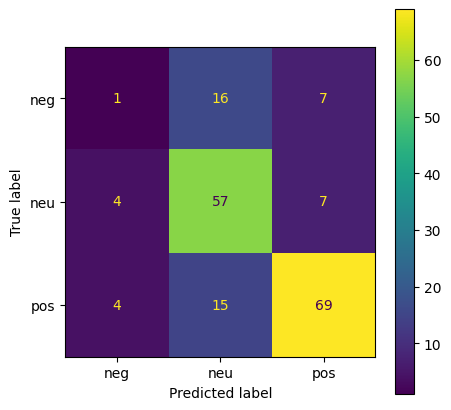

In [17]:
# test_bow = cvec.transform(X_test)
prediction1 = model1.predict(X_test)
showConfisionMatrix(y_test, prediction1)
print("--"*30)
print(classification_report(prediction1,y_test))

In [18]:
model2 = svm.SVC()
model2.fit(X_train, y_train)

SVC()

Accuracy score: 0.6722
------------------------------------------------------------
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00         0
         neu       0.82      0.60      0.69        94
         pos       0.74      0.76      0.75        86

    accuracy                           0.67       180
   macro avg       0.52      0.45      0.48       180
weighted avg       0.78      0.67      0.72       180



c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


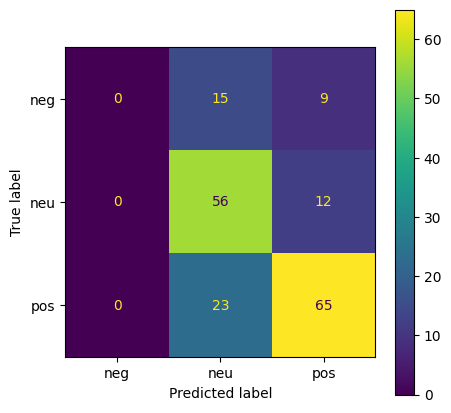

In [19]:
prediction2 = model2.predict(X_test)
showConfisionMatrix(y_test, prediction2)
print("--"*30)
print(classification_report(prediction2,y_test))

In [20]:
model3 = MultinomialNB()
model3.fit(X_train, y_train)

MultinomialNB()

Accuracy score: 0.5889
------------------------------------------------------------
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00         0
         neu       0.82      0.60      0.69        94
         pos       0.74      0.76      0.75        86

    accuracy                           0.67       180
   macro avg       0.52      0.45      0.48       180
weighted avg       0.78      0.67      0.72       180



c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


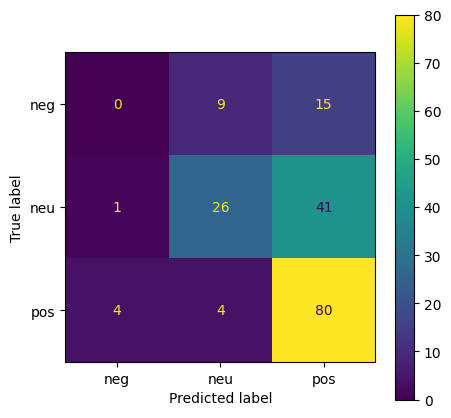

In [23]:
prediction3 = model3.predict(X_test)
showConfisionMatrix(y_test, prediction3)
print("--"*30)
print(classification_report(prediction2,y_test))